# Preprocessing Strategy 2: Advanced Imputation
## Approach: KNN Imputation and MICE (Multiple Imputation by Chained Equations)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 1. Load Data

In [2]:
df = pd.read_csv('data/clinical_genotype_HGB.csv')
print(f"Original shape: {df.shape}")
print(f"Target variable distribution:\n{df['undetectable'].value_counts()}")

Original shape: (45920, 48)
Target variable distribution:
undetectable
0.0    21947
1.0    11064
Name: count, dtype: int64


## 2. Feature Selection

In [3]:
# Define features to exclude (same as Strategy 1 for consistency)
exclude_features = [
    'wihsid', 'bsdate', 'bsvisit', 'dob', 'date',
    'lnegdate', 'fposdate', 'frstartd', 'frstaidd', 'frstdthd',
    'undetectable', 'HIV', 'r',
    'vload', 'CD4N', 'CD8N',  # Use transformed versions
]

feature_cols = [col for col in df.columns if col not in exclude_features]

# Separate features and target
X = df[feature_cols].copy()
y = df['undetectable'].copy()

# Remove rows where target is missing
mask = y.notna()
X = X[mask]
y = y[mask]

print(f"Data shape: {X.shape}")
print(f"Number of features: {len(feature_cols)}")

Data shape: (33011, 32)
Number of features: 32


## 3. Identify and Encode Categorical Features First

In [4]:
# Identify feature types
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")

# Encode categorical features before imputation (required for KNN and MICE)
label_encoders = {}
if len(categorical_features) > 0:
    for col in categorical_features:
        le = LabelEncoder()
        # Handle missing values by filling with a placeholder
        # Convert to string first to avoid Categorical issues
        X[col] = X[col].astype(str).replace('nan', 'MISSING')
        X[col] = le.fit_transform(X[col])
        label_encoders[col] = le
    print(f"Categorical features encoded: {categorical_features}")

# Now all features are numeric
all_numeric_features = X.columns.tolist()

Numeric features: 23
Categorical features: 9
Categorical features encoded: ['call', 'genotype', 'genotype3', 'APOBEC', 'APOB', 'APOBgr', 'Hgb', 'Hgbgen', 'HgbgenSS']


## 4. Split Data

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (26408, 32)
Test set: (6603, 32)


## 5. Strategy 2a: KNN Imputation

In [6]:
print("Applying KNN Imputation...")
print("KNN imputes missing values using k-nearest neighbors based on feature similarity")

# Use k=5 neighbors (common choice)
knn_imputer = KNNImputer(n_neighbors=5, weights='distance')

# Fit on training data and transform both sets
X_train_knn = knn_imputer.fit_transform(X_train)
X_test_knn = knn_imputer.transform(X_test)

# Convert back to DataFrame
X_train_knn = pd.DataFrame(X_train_knn, columns=X_train.columns, index=X_train.index)
X_test_knn = pd.DataFrame(X_test_knn, columns=X_test.columns, index=X_test.index)

print(f"KNN Imputation completed")
print(f"Missing values in train: {X_train_knn.isnull().sum().sum()}")
print(f"Missing values in test: {X_test_knn.isnull().sum().sum()}")

Applying KNN Imputation...
KNN imputes missing values using k-nearest neighbors based on feature similarity


KNN Imputation completed
Missing values in train: 0
Missing values in test: 0


## 6. Scale KNN-Imputed Data

In [7]:
scaler_knn = StandardScaler()
X_train_knn_scaled = scaler_knn.fit_transform(X_train_knn)
X_test_knn_scaled = scaler_knn.transform(X_test_knn)

X_train_knn_scaled = pd.DataFrame(X_train_knn_scaled, columns=X_train_knn.columns, index=X_train_knn.index)
X_test_knn_scaled = pd.DataFrame(X_test_knn_scaled, columns=X_test_knn.columns, index=X_test_knn.index)

print("KNN-imputed data scaled")

KNN-imputed data scaled


## 7. Strategy 2b: MICE Imputation

In [8]:
print("Applying MICE (Multiple Imputation by Chained Equations)...")
print("MICE models each feature with missing values as a function of other features")
print("This can take several minutes for large datasets...")

# Use IterativeImputer (MICE implementation)
# max_iter=10 for reasonable computation time, random_state for reproducibility
mice_imputer = IterativeImputer(max_iter=10, random_state=RANDOM_STATE, verbose=0)

# Fit on training data and transform both sets
X_train_mice = mice_imputer.fit_transform(X_train)
X_test_mice = mice_imputer.transform(X_test)

# Convert back to DataFrame
X_train_mice = pd.DataFrame(X_train_mice, columns=X_train.columns, index=X_train.index)
X_test_mice = pd.DataFrame(X_test_mice, columns=X_test.columns, index=X_test.index)

print(f"MICE Imputation completed")
print(f"Missing values in train: {X_train_mice.isnull().sum().sum()}")
print(f"Missing values in test: {X_test_mice.isnull().sum().sum()}")

Applying MICE (Multiple Imputation by Chained Equations)...
MICE models each feature with missing values as a function of other features
This can take several minutes for large datasets...


MICE Imputation completed
Missing values in train: 0
Missing values in test: 0


## 8. Scale MICE-Imputed Data

In [9]:
scaler_mice = StandardScaler()
X_train_mice_scaled = scaler_mice.fit_transform(X_train_mice)
X_test_mice_scaled = scaler_mice.transform(X_test_mice)

X_train_mice_scaled = pd.DataFrame(X_train_mice_scaled, columns=X_train_mice.columns, index=X_train_mice.index)
X_test_mice_scaled = pd.DataFrame(X_test_mice_scaled, columns=X_test_mice.columns, index=X_test_mice.index)

print("MICE-imputed data scaled")

MICE-imputed data scaled


## 9. Compare Imputation Methods

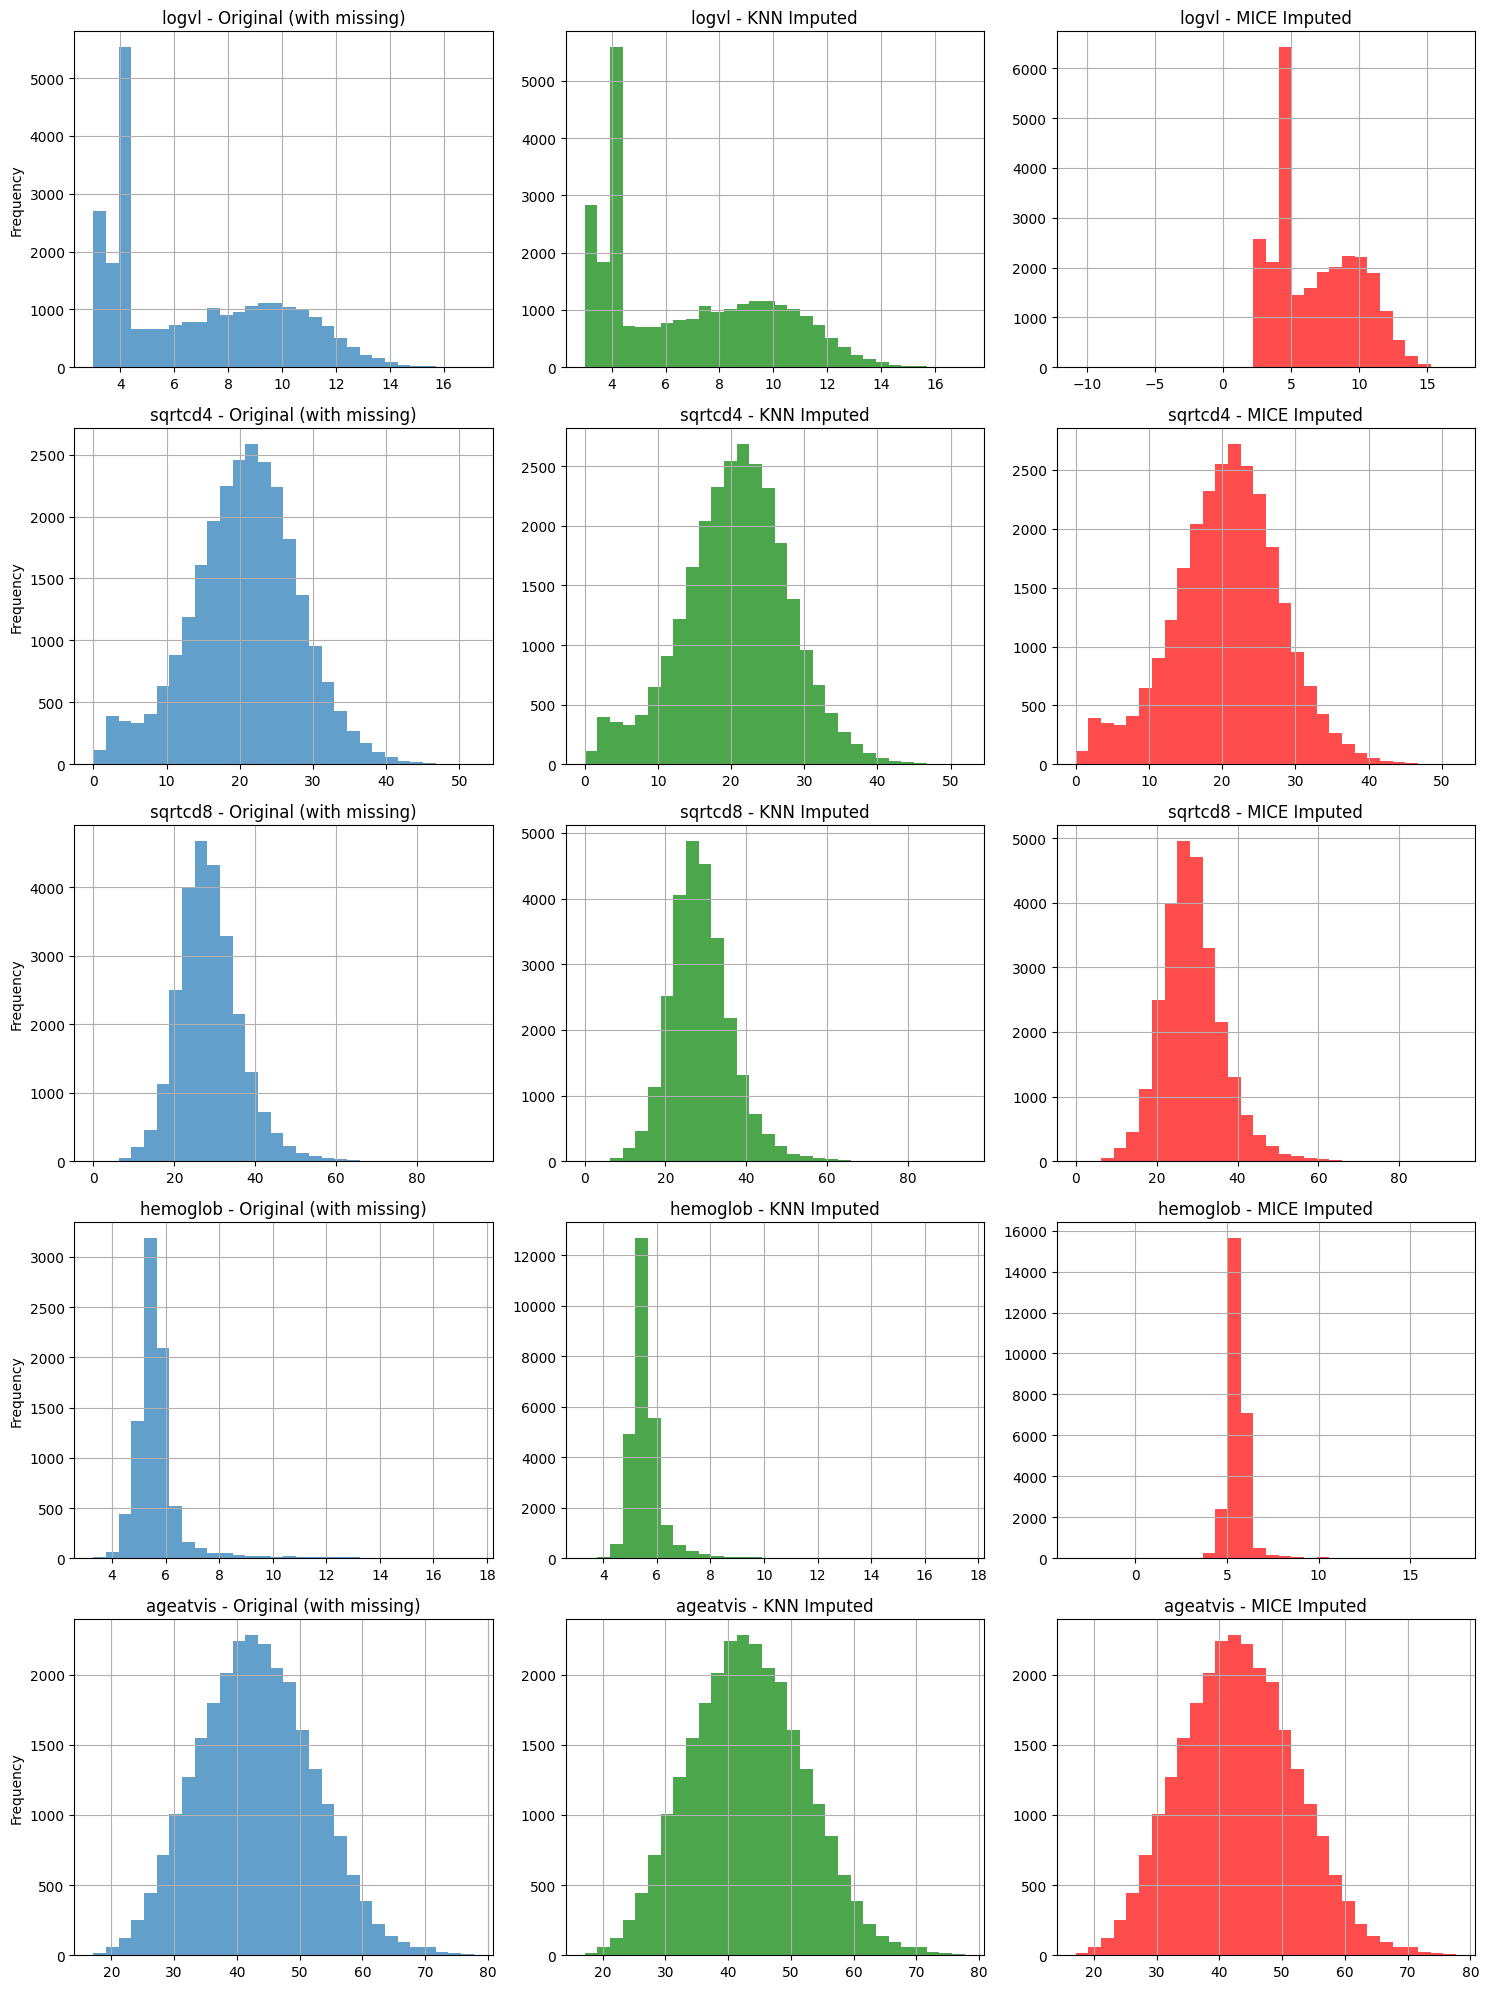

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select a few features to compare
compare_features = ['logvl', 'sqrtcd4', 'sqrtcd8', 'hemoglob', 'ageatvis']
compare_features = [f for f in compare_features if f in X_train.columns]

fig, axes = plt.subplots(len(compare_features), 3, figsize=(15, 4*len(compare_features)))

for idx, feature in enumerate(compare_features):
    # Original distribution (with missing values)
    X_train[feature].hist(bins=30, ax=axes[idx, 0], alpha=0.7)
    axes[idx, 0].set_title(f'{feature} - Original (with missing)')
    axes[idx, 0].set_ylabel('Frequency')
    
    # KNN imputed
    X_train_knn[feature].hist(bins=30, ax=axes[idx, 1], alpha=0.7, color='green')
    axes[idx, 1].set_title(f'{feature} - KNN Imputed')
    
    # MICE imputed
    X_train_mice[feature].hist(bins=30, ax=axes[idx, 2], alpha=0.7, color='red')
    axes[idx, 2].set_title(f'{feature} - MICE Imputed')

plt.tight_layout()
plt.show()

## 10. Save Preprocessed Data

In [11]:
import pickle
import os

os.makedirs('preprocessed_data', exist_ok=True)

# Save KNN-imputed data
X_train_knn_scaled.to_csv('preprocessed_data/strategy2a_knn_X_train.csv', index=False)
X_test_knn_scaled.to_csv('preprocessed_data/strategy2a_knn_X_test.csv', index=False)

# Save MICE-imputed data
X_train_mice_scaled.to_csv('preprocessed_data/strategy2b_mice_X_train.csv', index=False)
X_test_mice_scaled.to_csv('preprocessed_data/strategy2b_mice_X_test.csv', index=False)

# Save targets (same for both)
y_train.to_csv('preprocessed_data/strategy2_y_train.csv', index=False, header=['undetectable'])
y_test.to_csv('preprocessed_data/strategy2_y_test.csv', index=False, header=['undetectable'])

# Save preprocessing objects for KNN
preprocessing_knn = {
    'imputer': knn_imputer,
    'scaler': scaler_knn,
    'label_encoders': label_encoders,
    'feature_cols': feature_cols,
    'categorical_features': categorical_features,
    'numeric_features': numeric_features
}

with open('preprocessed_data/strategy2a_knn_preprocessing_objects.pkl', 'wb') as f:
    pickle.dump(preprocessing_knn, f)

# Save preprocessing objects for MICE
preprocessing_mice = {
    'imputer': mice_imputer,
    'scaler': scaler_mice,
    'label_encoders': label_encoders,
    'feature_cols': feature_cols,
    'categorical_features': categorical_features,
    'numeric_features': numeric_features
}

with open('preprocessed_data/strategy2b_mice_preprocessing_objects.pkl', 'wb') as f:
    pickle.dump(preprocessing_mice, f)

print("All preprocessed data saved!")
print("\nKNN Imputation:")
print(f"  - strategy2a_knn_X_train.csv: {X_train_knn_scaled.shape}")
print(f"  - strategy2a_knn_X_test.csv: {X_test_knn_scaled.shape}")
print("\nMICE Imputation:")
print(f"  - strategy2b_mice_X_train.csv: {X_train_mice_scaled.shape}")
print(f"  - strategy2b_mice_X_test.csv: {X_test_mice_scaled.shape}")

All preprocessed data saved!

KNN Imputation:
  - strategy2a_knn_X_train.csv: (26408, 32)
  - strategy2a_knn_X_test.csv: (6603, 32)

MICE Imputation:
  - strategy2b_mice_X_train.csv: (26408, 32)
  - strategy2b_mice_X_test.csv: (6603, 32)


## 11. Summary

In [12]:
print("="*70)
print("PREPROCESSING STRATEGY 2 - ADVANCED IMPUTATION SUMMARY")
print("="*70)

print(f"\n1. Imputation Methods:")
print(f"   Strategy 2a - KNN Imputation:")
print(f"     - Algorithm: K-Nearest Neighbors (k=5)")
print(f"     - Approach: Impute based on similar samples")
print(f"     - Advantages: Captures local patterns, handles complex relationships")
print(f"\n   Strategy 2b - MICE Imputation:")
print(f"     - Algorithm: Multiple Imputation by Chained Equations")
print(f"     - Approach: Iteratively model each feature with missing values")
print(f"     - Advantages: Models feature relationships, robust predictions")

print(f"\n2. Data Splits (same for both):")
print(f"   - Training: {X_train_knn_scaled.shape[0]:,} samples")
print(f"   - Test: {X_test_knn_scaled.shape[0]:,} samples")
print(f"   - Features: {X_train_knn_scaled.shape[1]}")

print(f"\n3. Target Distribution:")
print(f"   - Suppressed (1): {(y_train==1).sum():,} ({(y_train==1).mean()*100:.2f}%)")
print(f"   - Not Suppressed (0): {(y_train==0).sum():,} ({(y_train==0).mean()*100:.2f}%)")

print(f"\n4. Key Differences from Strategy 1:")
print(f"   - Uses neighbor-based and iterative imputation")
print(f"   - Better handles complex missing data patterns")
print(f"   - More computationally expensive")
print(f"   - May capture non-linear relationships")

print("\n" + "="*70)
print("Data ready for modeling with two imputation variants!")
print("="*70)

PREPROCESSING STRATEGY 2 - ADVANCED IMPUTATION SUMMARY

1. Imputation Methods:
   Strategy 2a - KNN Imputation:
     - Algorithm: K-Nearest Neighbors (k=5)
     - Approach: Impute based on similar samples
     - Advantages: Captures local patterns, handles complex relationships

   Strategy 2b - MICE Imputation:
     - Algorithm: Multiple Imputation by Chained Equations
     - Approach: Iteratively model each feature with missing values
     - Advantages: Models feature relationships, robust predictions

2. Data Splits (same for both):
   - Training: 26,408 samples
   - Test: 6,603 samples
   - Features: 32

3. Target Distribution:
   - Suppressed (1): 8,851 (33.52%)
   - Not Suppressed (0): 17,557 (66.48%)

4. Key Differences from Strategy 1:
   - Uses neighbor-based and iterative imputation
   - Better handles complex missing data patterns
   - More computationally expensive
   - May capture non-linear relationships

Data ready for modeling with two imputation variants!
